(216, 216)


/var/folders/7t/065x1t751d328nctyly8v49r0000gn/T/ipykernel_6937/3075998553.py:14: RuntimeWarning: divide by zero encountered in log
  ax[0].imshow(np.log(psd_1))
/var/folders/7t/065x1t751d328nctyly8v49r0000gn/T/ipykernel_6937/3075998553.py:27: RuntimeWarning: divide by zero encountered in log
  ax[1].imshow(np.log(psd_2))
/var/folders/7t/065x1t751d328nctyly8v49r0000gn/T/ipykernel_6937/3075998553.py:40: RuntimeWarning: divide by zero encountered in log
  ax[2].imshow(np.log(psd_3))
/var/folders/7t/065x1t751d328nctyly8v49r0000gn/T/ipykernel_6937/3075998553.py:47: RuntimeWarning: divide by zero encountered in log
  ax[2].imshow(np.log(psd_3))
/var/folders/7t/065x1t751d328nctyly8v49r0000gn/T/ipykernel_6937/3075998553.py:58: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(psd))


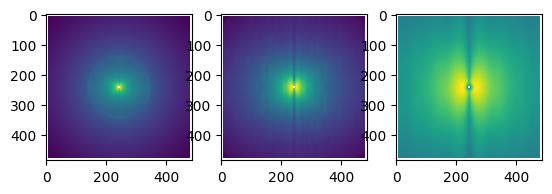

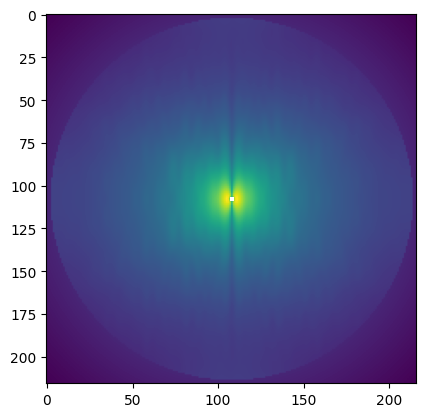

In [9]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3)


hdul = fits.open("/Users/pjanin/Documents/GitHub/FATMOSS/devs/HarmoniLTAO_JQ2.fits")

primary_hdu = hdul[0]
psd_1 = hdul[4].data[1, :, :]

psd_1 = np.pad(psd_1, 5)
ax[0].imshow(np.log(psd_1))


hdul = fits.open("/Users/pjanin/Documents/GitHub/FATMOSS/devs/HarmoniLTAO_JQ2_2.fits")

primary_hdu = hdul[0]
psd_2 = hdul[4].data[1, :, :]

N = psd_2.shape[0]
psd_2 = psd_2[
    N // 2 - 476 // 2 : N // 2 + 476 // 2, N // 2 - 476 // 2 : N // 2 + 476 // 2
]
psd_2 = np.pad(psd_2, 5)
ax[1].imshow(np.log(psd_2))


hdul = fits.open("/Users/pjanin/Documents/GitHub/FATMOSS/devs/HarmoniLTAO_JQ2_3.fits")

primary_hdu = hdul[0]
psd_3 = hdul[4].data[1, :, :]

N = psd_3.shape[0]
psd_3 = psd_3[
    N // 2 - 476 // 2 : N // 2 + 476 // 2, N // 2 - 476 // 2 : N // 2 + 476 // 2
]
psd_3 = np.pad(psd_3, 5)
ax[2].imshow(np.log(psd_3))


hdul = fits.open("/Users/pjanin/Documents/GitHub/FATMOSS/devs/HarmoniLTAO_JQ2_undersampled.fits")

primary_hdu = hdul[0]
psd = hdul[4].data[1, :, :]
ax[2].imshow(np.log(psd_3))

# psd = np.dstack(
#     (psd_1[:, :, np.newaxis], psd_2[:, :, np.newaxis], psd_3[:, :, np.newaxis])
# )

# psd = psd_1[:216,:216,np.newaxis]

print(psd.shape)

plt.figure()
plt.imshow(np.log(psd))
plt.show()

# psd = np.pad(psd, 5)
# psd.shape
# plt.imshow(np.log(psd))

# psd.shape[0]/(3**3)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from phase_generator import *

In [11]:
# Parameters
D = 39  # Size of the phase screen [m]
r0 = 0.1  # Fried parameter [m]
L0 = 25.0  # Outer scale [m]

dx = r0 / 3.0  # Spatial sampling interval [m/pixel], make sure r0 is Nyquist sampled
dt = 0.001  # Time step [s/step]

wind_speed = 40  # [m/s]
wind_direction = 15  # [degree]
boiling_factor = 500  # [a.u], need to figure them out

screen_generator = CascadedPhaseGenerator(
    D, dx, dt, batch_size=config["batch_size"], n_cascades=1
)
screen_generator.AddLayer(
    1.0, r0, L0, wind_speed, wind_direction, boiling_factor, PSDs=psd
)
# screen_generator.AddLayer(0.5, r0/2., L0, wind_speed*2, wind_direction*4, boiling_factor)

/Users/pjanin/Documents/GitHub/FATMOSS/phase_generator.py:20: UserWarning: Layer height is not yet properly implemented.
  warnings.warn("Layer height is not yet properly implemented.")


In [13]:
if GPU_flag:
    start = cp.cuda.Event()
    end   = cp.cuda.Event()

total_time = 0
screens_cascade = []

for i in tqdm(range(1000)):
    if GPU_flag:
        start.record()
    else:
        start = time.time()
        
    screens_cascade.append(screen_generator.GetScreenByTimestep(i))
    
    if GPU_flag:
        end.record()
        end.synchronize()
        total_time += cp.cuda.get_elapsed_time(start, end)  # Time in [ms]
    else:
        end = time.time()
        total_time += (end-start) * 1000

screens_cascade = xp.dstack(screens_cascade)

print(f"Total elapsed time: {np.round(total_time/1e3,1)} [s]")
print(f"Time per sreen: {np.round(total_time/screen_generator.num_screens).astype(xp.uint16)} [ms]")

100%|██████████| 1000/1000 [00:02<00:00, 457.00it/s]

Total elapsed time: 2.2 [s]
Time per sreen: 4 [ms]


In [11]:
SaveVideo(screens_cascade)

Writing video...


  0%|          | 0/100 [00:00<?, ?it/s]/Users/pjanin/Documents/GitHub/FATMOSS/misc.py:58: RuntimeWarning: invalid value encountered in divide
  buf = (frames_batch[..., i] + normalizer) / 2 / normalizer
/Users/pjanin/anaconda3/envs/DOSSA/lib/python3.10/site-packages/skimage/transform/_warps.py:673: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/pjanin/anaconda3/envs/DOSSA/lib/python3.10/site-packages/skimage/transform/_warps.py:677: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|██████████| 100/100 [00:02<00:00, 37.34it/s]


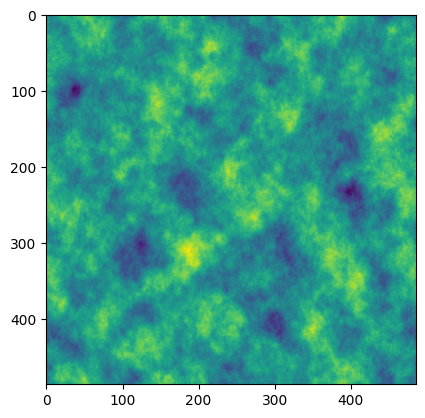

MovieWriter Pillow unavailable; using Pillow instead.


IndexError: index 100 is out of bounds for axis 2 with size 100

In [45]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

fig, ax = plt.subplots()

scat = ax.imshow(screens_cascade[:,:,0])


def animate(i):
    ax.imshow(screens_cascade[:,:,i])
    return scat,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(screens_cascade) - 1, interval=1)

# To save the animation using Pillow as a gif
# writer = animation.PillowWriter(fps=15,
#                                 metadata=dict(artist='Me'),
#                                 bitrate=1800)
# ani.save('scatter.gif', writer=writer)

plt.show()

ani.save('./output/animation.gif', writer='Pillow', fps=10)

In [3]:
import numpy as np
import cupy as cp
import pyfftw
import time

def generate_data(shape, num_arrays):
    """Generate random data for a batch of 2D FFTs."""
    return np.random.random((num_arrays, *shape))

def time_np_fft_batch(data):
    """Measure the time taken by NumPy for a batch of 2D FFTs."""
    start_time = time.time()
    results = np.fft.fft2(data, axes=(-2, -1))
    end_time = time.time()
    return end_time - start_time

def time_cp_fft_batch(data):
    """Measure the time taken by CuPy for a batch of 2D FFTs."""
    data_gpu = cp.asarray(data)
    start_time = time.time()
    results_gpu = cp.fft.fft2(data_gpu, axes=(-2, -1))
    cp.cuda.Stream.null.synchronize()  # Ensure all operations are complete
    end_time = time.time()
    return end_time - start_time

def time_pyfftw_fft_batch(data):
    """Measure the time taken by pyFFTW for a batch of 2D FFTs."""
    fftw_object = pyfftw.builders.fft2(data, axes=(-2, -1), threads=4)
    start_time = time.time()
    results = fftw_object()
    end_time = time.time()
    return end_time - start_time

def compare_ffts_batch(shape, num_arrays):
    """Compare the 2D FFT computation time for a batch between NumPy, CuPy, and pyFFTW."""
    data = generate_data(shape, num_arrays)
    
    np_time = time_np_fft_batch(data)
    cp_time = time_cp_fft_batch(data)
    pyfftw_time = time_pyfftw_fft_batch(data)
    
    print(f"NumPy 2D FFT time for batch of {num_arrays} arrays of shape {shape}: {np_time:.6f} seconds")
    print(f"CuPy 2D FFT time for batch of {num_arrays} arrays of shape {shape}: {cp_time:.6f} seconds")
    print(f"pyFFTW 2D FFT time for batch of {num_arrays} arrays of shape {shape}: {pyfftw_time:.6f} seconds")

if __name__ == "__main__":
    shape = (486, 486)
    num_arrays = 100000
    compare_ffts_batch(shape, num_arrays)


: 